<a href="https://colab.research.google.com/github/kopalgarg/time-series-forecasting/blob/main/ts_forecasting_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import matplotlib as plt
%pylab inline
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [6]:
data1 = pd.read_csv("NEW-DATA-1.T15.txt", sep=' ')
data2 = pd.read_csv("NEW-DATA-2.T15.txt", sep=' ')

In [7]:
target = '3:Temperature_Comedor_Sensor'
cols = [
    '3:Temperature_Comedor_Sensor',
 '4:Temperature_Habitacion_Sensor',
 '5:Weather_Temperature',
 '6:CO2_Comedor_Sensor',
 '7:CO2_Habitacion_Sensor',
 '8:Humedad_Comedor_Sensor',
 '9:Humedad_Habitacion_Sensor',
 '10:Lighting_Comedor_Sensor',
 '11:Lighting_Habitacion_Sensor',
 '12:Precipitacion',
 '13:Meteo_Exterior_Crepusculo',
 '14:Meteo_Exterior_Viento',
 '15:Meteo_Exterior_Sol_Oest',
 '16:Meteo_Exterior_Sol_Est',
 '20:Exterior_Entalpic_2',
 '21:Exterior_Entalpic_turbo',
 '22:Temperature_Exterior_Sensor']

In [8]:
train_size = 3200
val_size = 400
depth = 90
batch_size = 128
prediction_horizon = 1

In [9]:
X_train1 = np.zeros((len(data1), depth, len(cols)))
y_train1 = np.zeros((len(data1), 1))

In [10]:
for i, name in enumerate(cols):
    for j in range(depth):
        X_train1[:, j, i] = data1[name].shift(depth - j - 1).fillna(method="bfill")

In [11]:
y_train1 = data1[target].shift(-prediction_horizon).fillna(method='ffill')

In [12]:
X_train1 = X_train1[depth:-prediction_horizon]
y_train1 = y_train1[depth:-prediction_horizon]

In [13]:
X2 = np.zeros((len(data2), depth, len(cols)))
y2 = np.zeros((len(data2), 1))

In [14]:
for i, name in enumerate(cols):
    for j in range(depth):
        X2[:, j, i] = data2[name].shift(depth - j - 1).fillna(method="bfill")
y2 = data2[target].shift(-prediction_horizon).fillna(method='ffill')

In [15]:
X_train2 = X2[:train_size - len(data1)]
y_train2 = y2[:train_size - len(data1)]

X_val = X2[train_size - len(data1):train_size - len(data1) + val_size]
y_val = y2[train_size - len(data1):train_size - len(data1) + val_size]

X_test = X2[train_size - len(data1) + val_size:]
y_test = y2[train_size - len(data1) + val_size:]

In [16]:
X_train2 = X_train2[depth:]
y_train2 = y_train2[depth:]

In [17]:
X_train = np.concatenate([X_train1, X_train2], axis=0)
y_train = np.concatenate([y_train1, y_train2], axis=0)

In [18]:
X_train.shape, y_train.shape


((3019, 90, 17), (3019,))

In [19]:
X_train_min, y_train_min = X_train.min(axis=0), y_train.min(axis=0)
X_train_max, y_train_max = X_train.max(axis=0), y_train.max(axis=0)

In [20]:
X_train = (X_train - X_train_min)/(X_train_max - X_train_min + 1e-9)
X_val = (X_val - X_train_min)/(X_train_max - X_train_min + 1e-9)
X_test = (X_test - X_train_min)/(X_train_max - X_train_min + 1e-9)

y_train = (y_train - y_train_min)/(y_train_max - y_train_min + 1e-9)
y_val = (y_val - y_train_min)/(y_train_max - y_train_min + 1e-9)
y_test = (y_test - y_train_min)/(y_train_max - y_train_min + 1e-9)

In [21]:
X_train_t = torch.Tensor(X_train)
X_val_t = torch.Tensor(X_val)
X_test_t = torch.Tensor(X_test)
y_train_t = torch.Tensor(y_train)
y_val_t = torch.Tensor(y_val.values)
y_test_t = torch.Tensor(y_test.values)

In [22]:
train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), shuffle=True, batch_size=batch_size)
val_loader = DataLoader(TensorDataset(X_val_t, y_val_t), shuffle=False, batch_size=batch_size)
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), shuffle=False, batch_size=batch_size)

In [23]:
class ConvRNN(nn.Module):
    def __init__(self, input_dim, timesteps, output_dim, kernel_size1=7, kernel_size2=5, kernel_size3=3, 
                 n_channels1=32, n_channels2=32, n_channels3=32, n_units1=32, n_units2=32, n_units3=32):
        super().__init__()
        self.avg_pool1 = nn.AvgPool1d(2, 2)
        self.avg_pool2 = nn.AvgPool1d(4, 4)
        self.conv11 = nn.Conv1d(input_dim, n_channels1, kernel_size=kernel_size1)
        self.conv12 = nn.Conv1d(n_channels1, n_channels1, kernel_size=kernel_size1)
        self.conv21 = nn.Conv1d(input_dim, n_channels2, kernel_size=kernel_size2)
        self.conv22 = nn.Conv1d(n_channels2, n_channels2, kernel_size=kernel_size2)
        self.conv31 = nn.Conv1d(input_dim, n_channels3, kernel_size=kernel_size3)
        self.conv32 = nn.Conv1d(n_channels3, n_channels3, kernel_size=kernel_size3)
        self.gru1 = nn.GRU(n_channels1, n_units1, batch_first=True)
        self.gru2 = nn.GRU(n_channels2, n_units2, batch_first=True)
        self.gru3 = nn.GRU(n_channels3, n_units3, batch_first=True)
        self.linear1 = nn.Linear(n_units1+n_units2+n_units3, output_dim)
        self.linear2 = nn.Linear(input_dim*timesteps, output_dim)
        self.zp11 = nn.ConstantPad1d(((kernel_size1-1), 0), 0)
        self.zp12 = nn.ConstantPad1d(((kernel_size1-1), 0), 0)
        self.zp21 = nn.ConstantPad1d(((kernel_size2-1), 0), 0)
        self.zp22 = nn.ConstantPad1d(((kernel_size2-1), 0), 0)
        self.zp31 = nn.ConstantPad1d(((kernel_size3-1), 0), 0)
        self.zp32 = nn.ConstantPad1d(((kernel_size3-1), 0), 0)
        
    def forward(self, x):
        x = x.permute(0, 2, 1)
        # line1
        y1 = self.zp11(x)
        y1 = torch.relu(self.conv11(y1))
        y1 = self.zp12(y1)
        y1 = torch.relu(self.conv12(y1))
        y1 = y1.permute(0, 2, 1)
        out, h1 = self.gru1(y1)
        # line2
        y2 = self.avg_pool1(x)
        y2 = self.zp21(y2)
        y2 = torch.relu(self.conv21(y2))
        y2 = self.zp22(y2)
        y2 = torch.relu(self.conv22(y2))
        y2 = y2.permute(0, 2, 1)
        out, h2 = self.gru2(y2)
        # line3 
        y3 = self.avg_pool2(x)
        y3 = self.zp31(y3)
        y3 = torch.relu(self.conv31(y3))
        y3 = self.zp32(y3)
        y3 = torch.relu(self.conv32(y3))
        y3 = y3.permute(0, 2, 1)
        out, h3 = self.gru3(y3)
        h = torch.cat([h1[-1], h2[-1], h3[-1]], dim=1)
        out1 = self.linear1(h)
        out2 = self.linear2(x.contiguous().view(x.shape[0], -1))
        out = out1 + out2
        return out

In [24]:
model = ConvRNN(X_train.shape[2], X_train.shape[1], 1, n_channels1=128, n_channels2=128, n_channels3=128,
                n_units1=128, n_units2=128, n_units3=128).cuda()
opt = torch.optim.Adam(model.parameters(), lr=0.001)

In [25]:
epoch_scheduler = torch.optim.lr_scheduler.StepLR(opt, 20, gamma=0.9)


In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import time

Saving...
Iter:  0 train:  0.24216198599569239 val:  0.1623403336185683
Iter time:  0.8635621759999879
mse:  12.755523 mae:  3.0259752


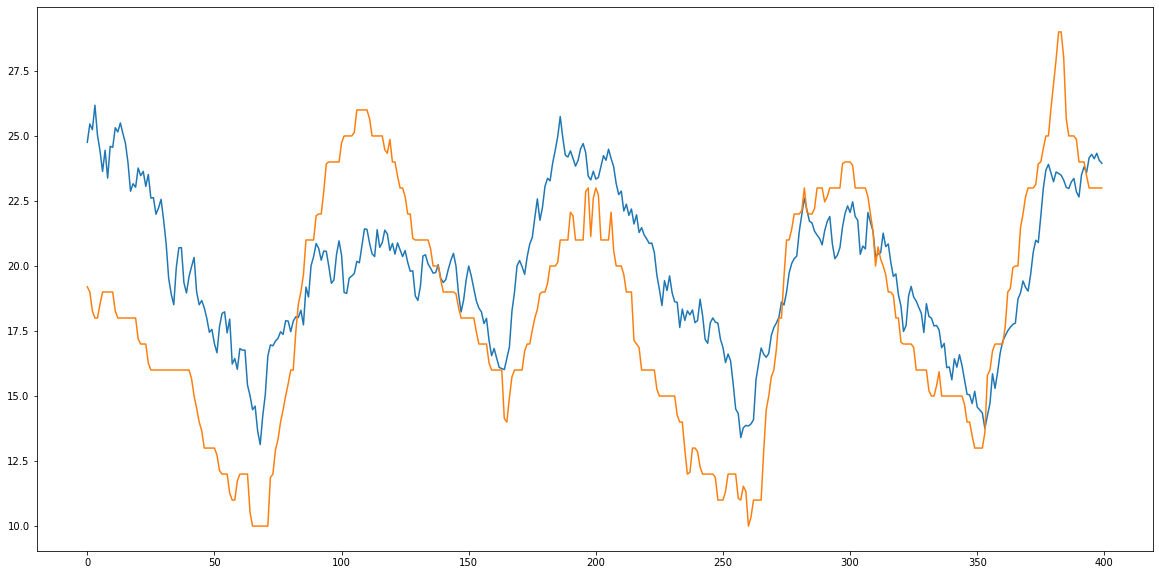

Saving...
Iter:  1 train:  0.10776640902560805 val:  0.12557487987883365
Iter time:  0.5190416299999754
Saving...
Iter:  2 train:  0.0904497995953797 val:  0.11756126704347712
Iter time:  0.5126449949999881
Saving...
Iter:  3 train:  0.07498072625385652 val:  0.10346398131467326
Iter time:  0.5127566090000073
Iter:  4 train:  0.06392377235458434 val:  0.11075819831571605
Iter time:  0.5065946420000103
Saving...
Iter:  5 train:  0.057485566994748355 val:  0.09768342116969099
Iter time:  0.5207341870000164
Saving...
Iter:  6 train:  0.049965482230968306 val:  0.08092266130847971
Iter time:  0.5226317919999985
Saving...
Iter:  7 train:  0.04575608364465562 val:  0.08024124349187947
Iter time:  0.5175639890000241
Saving...
Iter:  8 train:  0.04353107771987638 val:  0.07552296309372936
Iter time:  0.5139191499999924
Saving...
Iter:  9 train:  0.044165718746488725 val:  0.07431173021641306
Iter time:  0.5166786959999854
Saving...
Iter:  10 train:  0.043761321665420294 val:  0.073747900866279

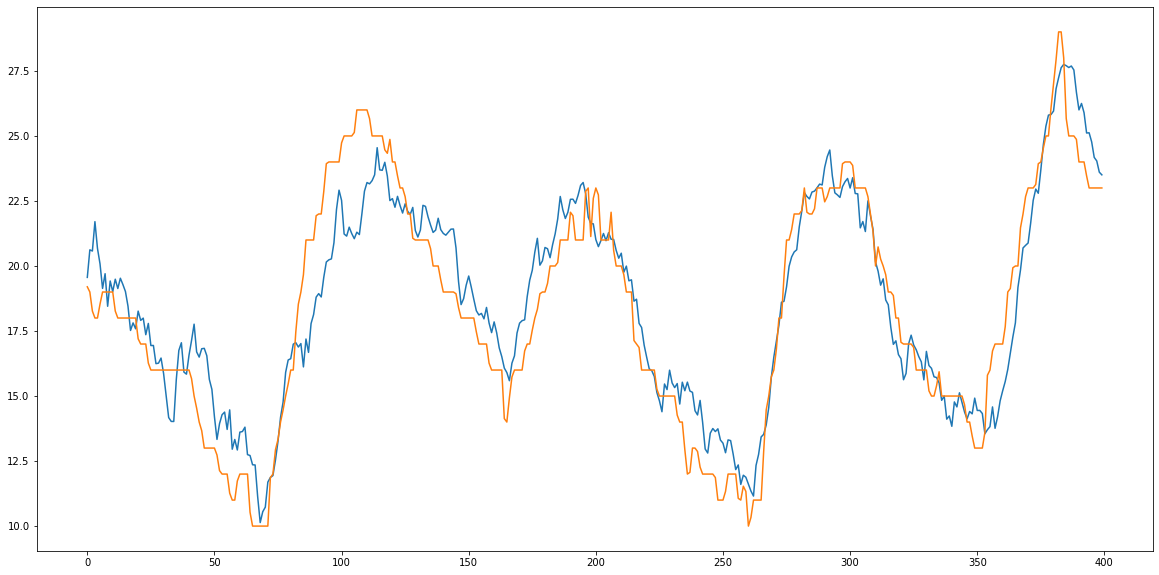

Saving...
Iter:  11 train:  0.04011508551030398 val:  0.07181336932573286
Iter time:  0.5124297460000093
Iter:  12 train:  0.038282062470506285 val:  0.07334321289857303
Iter time:  0.5052155059999848
Saving...
Iter:  13 train:  0.036708073964716516 val:  0.06916647444022327
Iter time:  0.517097471999989
Iter:  14 train:  0.036032190384052996 val:  0.07411005091172954
Iter time:  0.5038867589999825
Iter:  15 train:  0.03651231237187786 val:  0.07074918353212847
Iter time:  0.5095426169999939
Saving...
Iter:  16 train:  0.037052998750642954 val:  0.06871387768169815
Iter time:  0.5172662989999992
Iter:  17 train:  0.032195144469003636 val:  0.07111709913457614
Iter time:  0.5079797690000021
Iter:  18 train:  0.0314807697025903 val:  0.06905879765939033
Iter time:  0.508398341000003
Saving...
Iter:  19 train:  0.034630692011523544 val:  0.06712852512325788
Iter time:  0.5223200309999925
Saving...
Iter:  20 train:  0.03058423649304222 val:  0.06694631201355959
Iter time:  0.51985227800000

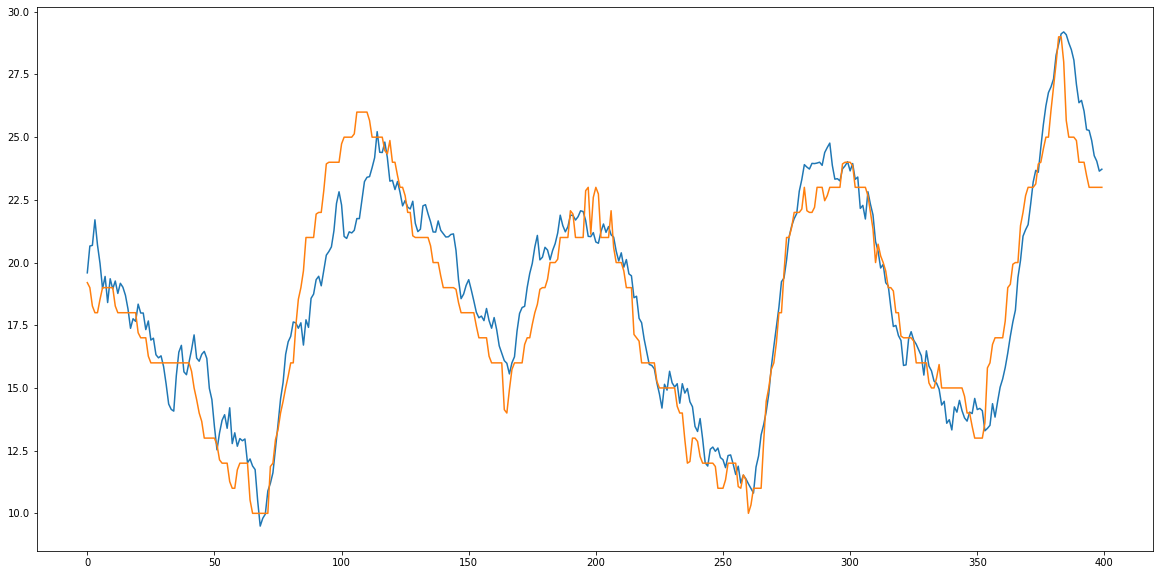

Iter:  21 train:  0.02985911493656769 val:  0.06886244946353476
Iter time:  0.5144494139999836
Saving...
Iter:  22 train:  0.02995191834220712 val:  0.06595950223966755
Iter time:  0.5161729889999833
Saving...
Iter:  23 train:  0.032211467952185054 val:  0.06329675281445066
Iter time:  0.5134573180000075
Iter:  24 train:  0.031672509919466865 val:  0.0667399035204435
Iter time:  0.5173448380000139
Iter:  25 train:  0.02770391367238565 val:  0.07541136481070743
Iter time:  0.5122517439999967
Iter:  26 train:  0.02756979562563703 val:  0.06615142060258838
Iter time:  0.5149805629999946
Saving...
Iter:  27 train:  0.0305340877635853 val:  0.062400065934183825
Iter time:  0.5152993430000095
Iter:  28 train:  0.02854826892602455 val:  0.06267153922014582
Iter time:  0.5139209510000171
Iter:  29 train:  0.02737626292523547 val:  0.06364486068605674
Iter time:  0.5113911409999901
Iter:  30 train:  0.02534062865178395 val:  0.06716223424650898
Iter time:  0.5075727810000217
mse:  2.1832104 mae

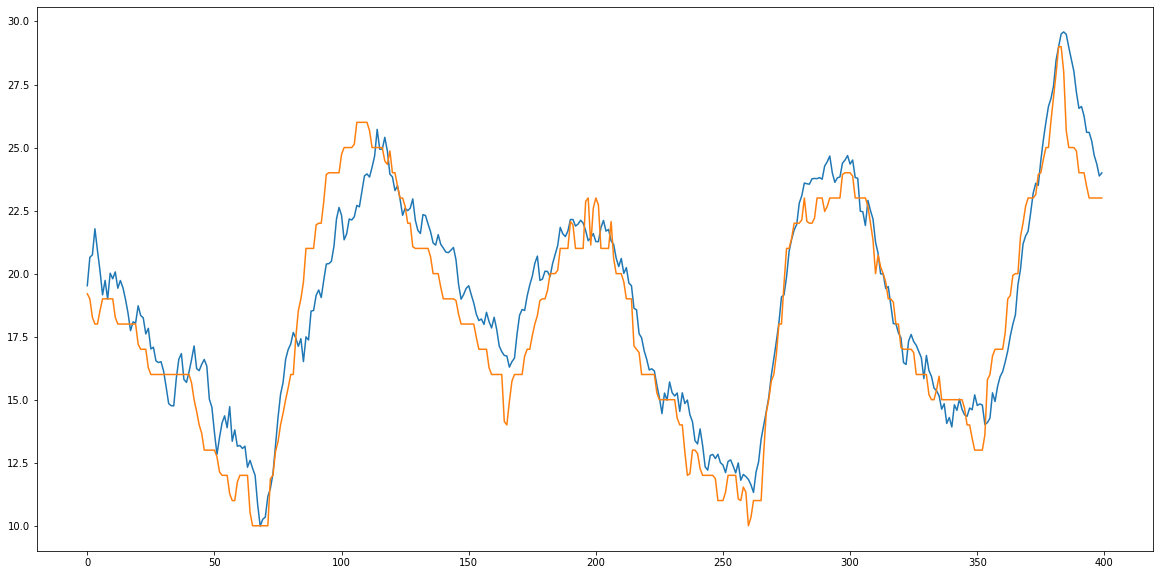

Saving...
Iter:  31 train:  0.02554386046987247 val:  0.06185440986432809
Iter time:  0.5215535830000135
Iter:  32 train:  0.02487384832720562 val:  0.06209850995979778
Iter time:  0.5111857379999947
Saving...
Iter:  33 train:  0.024717470369892885 val:  0.061568851663689285
Iter time:  0.5140136589999997
Iter:  34 train:  0.025130090582127014 val:  0.06198311078253862
Iter time:  0.5131683850000002
Iter:  35 train:  0.02377768759670654 val:  0.06205067019502177
Iter time:  0.5663926969999977
Iter:  36 train:  0.02359370416013712 val:  0.0636766443631092
Iter time:  0.508816392
Iter:  37 train:  0.02338882828170502 val:  0.06315021045701469
Iter time:  0.5164064219999887
Iter:  38 train:  0.023277362425623973 val:  0.06475442139477651
Iter time:  0.5145921370000224
Iter:  39 train:  0.025637817419270983 val:  0.0690657870666907
Iter time:  0.5165603920000024
Iter:  40 train:  0.023246475590261058 val:  0.06352359672435415
Iter time:  0.5107613739999977
mse:  1.9530597 mae:  1.0301399


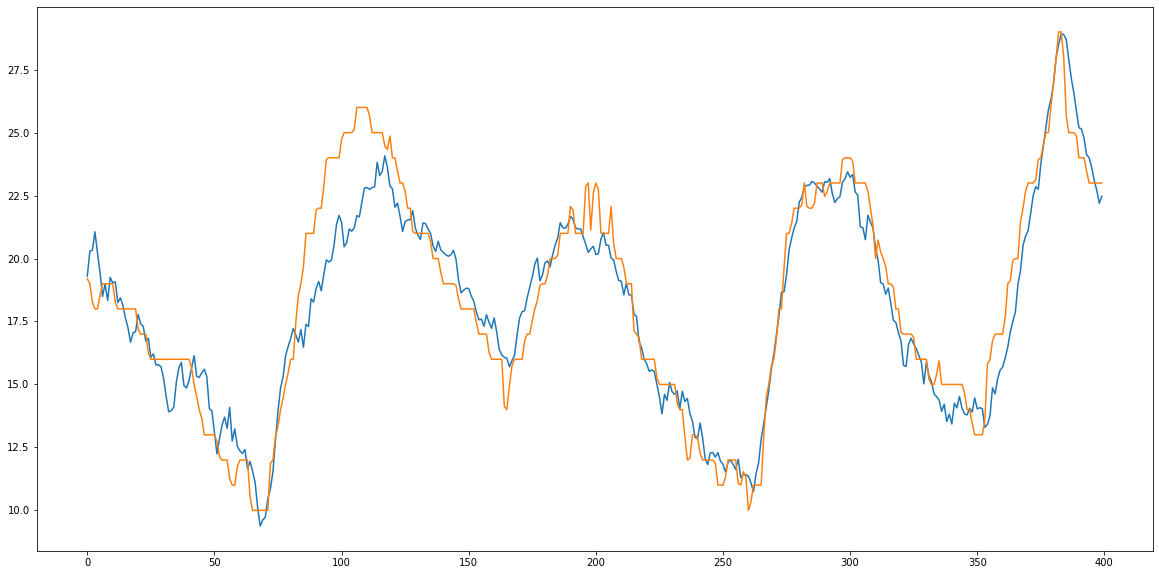

Iter:  41 train:  0.025825369187494392 val:  0.06403938085633497
Iter time:  0.5151199629999894
Iter:  42 train:  0.021906613051761576 val:  0.06443296261628924
Iter time:  0.5125449760000151
Saving...
Iter:  43 train:  0.02170001379170501 val:  0.06123585624051881
Iter time:  0.5198961520000012
Saving...
Iter:  44 train:  0.021133069952751615 val:  0.06072705500471836
Iter time:  0.5272756130000005
Saving...
Iter:  45 train:  0.023564868640202002 val:  0.060054514986805016
Iter time:  0.5225451360000193
Iter:  46 train:  0.0209746328193317 val:  0.06519963487269839
Iter time:  0.5189725010000075
Iter:  47 train:  0.02094282345953899 val:  0.06341093808586712
Iter time:  0.5181758720000005
Iter:  48 train:  0.022993214144362752 val:  0.06240359679681848
Iter time:  0.5204981100000055
Iter:  49 train:  0.024211643539291332 val:  0.06207857642908574
Iter time:  0.5119257489999995
Iter:  50 train:  0.022843267329100008 val:  0.0652660487140457
Iter time:  0.5178685529999996
mse:  2.061673

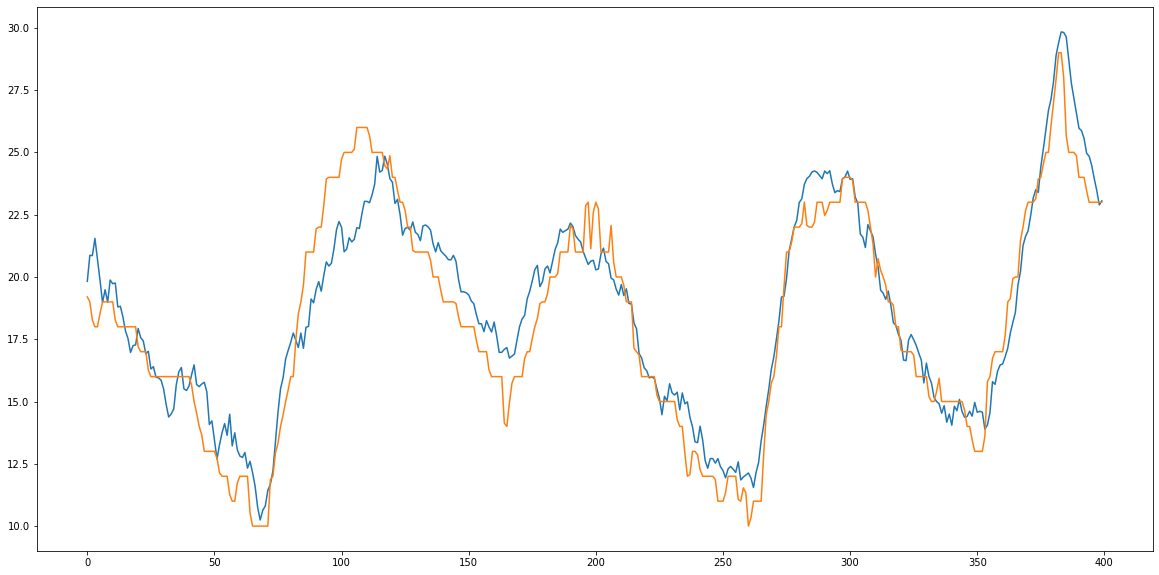

Iter:  51 train:  0.022466054641581298 val:  0.06055575705567888
Iter time:  0.5243187509999814
Saving...
Iter:  52 train:  0.020383268882069133 val:  0.0594709890974421
Iter time:  0.5218289369999809
Iter:  53 train:  0.019853774562073184 val:  0.0631228100047419
Iter time:  0.5231322920000139
Iter:  54 train:  0.02258087382878662 val:  0.06484485303561079
Iter time:  0.5177960160000055
Iter:  55 train:  0.020058562613521576 val:  0.06171567341826122
Iter time:  0.5180016980000062
Saving...
Iter:  56 train:  0.019833369334876762 val:  0.05937480142208823
Iter time:  0.5238259870000093
Iter:  57 train:  0.02073037614089408 val:  0.06409780762139791
Iter time:  0.5143830439999988
Iter:  58 train:  0.021034234600996488 val:  0.0610912208936094
Iter time:  0.5061473540000065
Iter:  59 train:  0.021092791418856355 val:  0.06157578466585689
Iter time:  0.5181240279999884
Saving...
Iter:  60 train:  0.020143843327894515 val:  0.0590072431192159
Iter time:  0.5170999439999946
mse:  1.6852176 

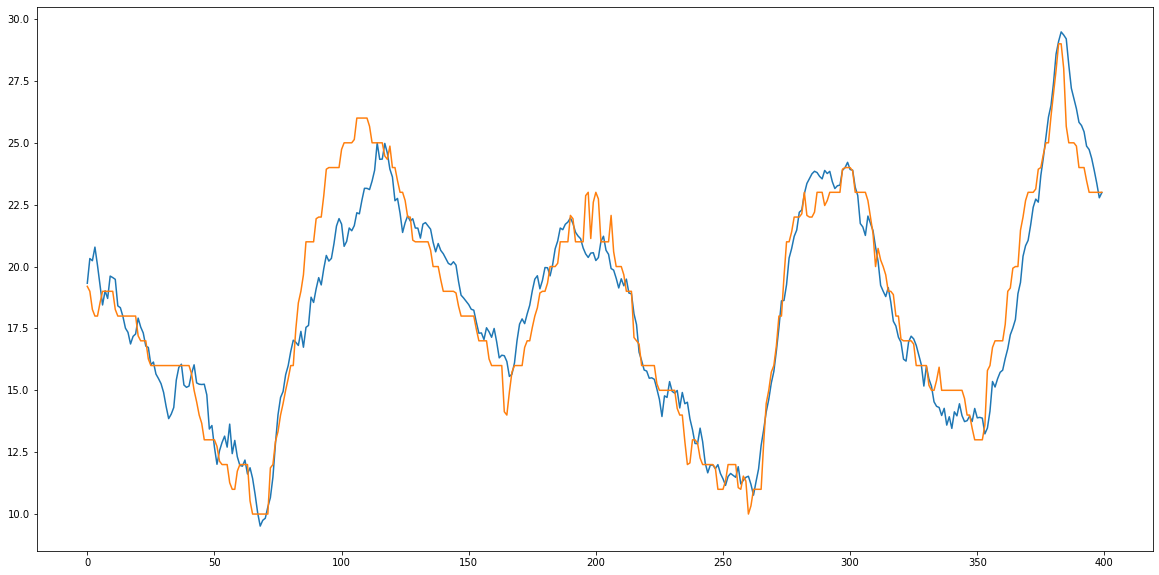

Saving...
Iter:  61 train:  0.01944538340364579 val:  0.05776391113954006
Iter time:  0.5324496030000034
Iter:  62 train:  0.017831942579910946 val:  0.05936680724690742
Iter time:  0.5186432010000033
Iter:  63 train:  0.019310646865391648 val:  0.06466066037480853
Iter time:  0.5186778350000054
Iter:  64 train:  0.018018376600141134 val:  0.059996662618286116
Iter time:  0.5149928649999822
Iter:  65 train:  0.017086323275501983 val:  0.06156077705068439
Iter time:  0.5176768870000217
Iter:  66 train:  0.019318935808540303 val:  0.06001376952680054
Iter time:  0.5202066610000031
Iter:  67 train:  0.022881688435419097 val:  0.06000199636227639
Iter time:  0.5193859599999939
Iter:  68 train:  0.01935387184300092 val:  0.06016408757762934
Iter time:  0.5143068819999996
Iter:  69 train:  0.018650712584008824 val:  0.059573027908472354
Iter time:  0.5205230519999873
Iter:  70 train:  0.017097351609449626 val:  0.06071518883689596
Iter time:  0.5192051069999764
mse:  1.7841856 mae:  1.041420

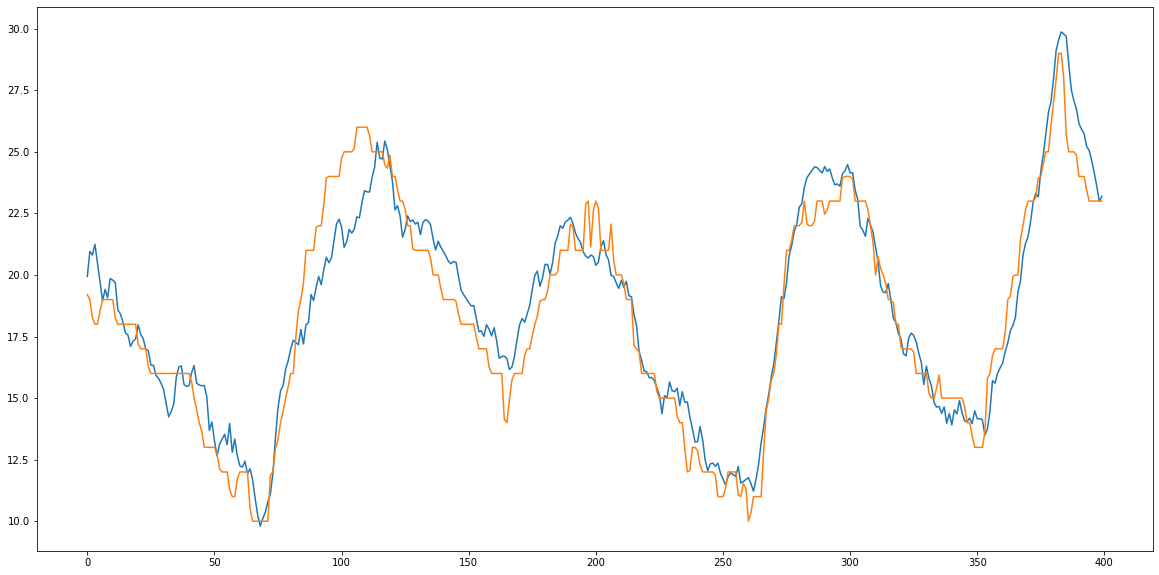

Iter:  71 train:  0.01772158014352163 val:  0.059880708706026464
Iter time:  0.5248615860000143
Iter:  72 train:  0.01839618079730556 val:  0.06642299216656135
Iter time:  0.5169884169999932
Iter:  73 train:  0.024162235379673585 val:  0.060525780971819036
Iter time:  0.5199253180000198
Iter:  74 train:  0.02140199435484236 val:  0.06198506781323339
Iter time:  0.5143536459999893
Iter:  75 train:  0.024500175781868524 val:  0.059328810707712884
Iter time:  0.5221268230000078
Iter:  76 train:  0.018298758237201986 val:  0.060702810065730216
Iter time:  0.5277422440000237
Iter:  77 train:  0.0182340337979648 val:  0.061009029671217734
Iter time:  0.5246126870000012
Iter:  78 train:  0.024632607992240783 val:  0.06503800858110527
Iter time:  0.5215059710000105
Iter:  79 train:  0.022707790832689322 val:  0.05930790090014888
Iter time:  0.52203453300001
Iter:  80 train:  0.018992330088035355 val:  0.06106626435031972
Iter time:  0.5121120740000151
mse:  1.8048788 mae:  0.9997175


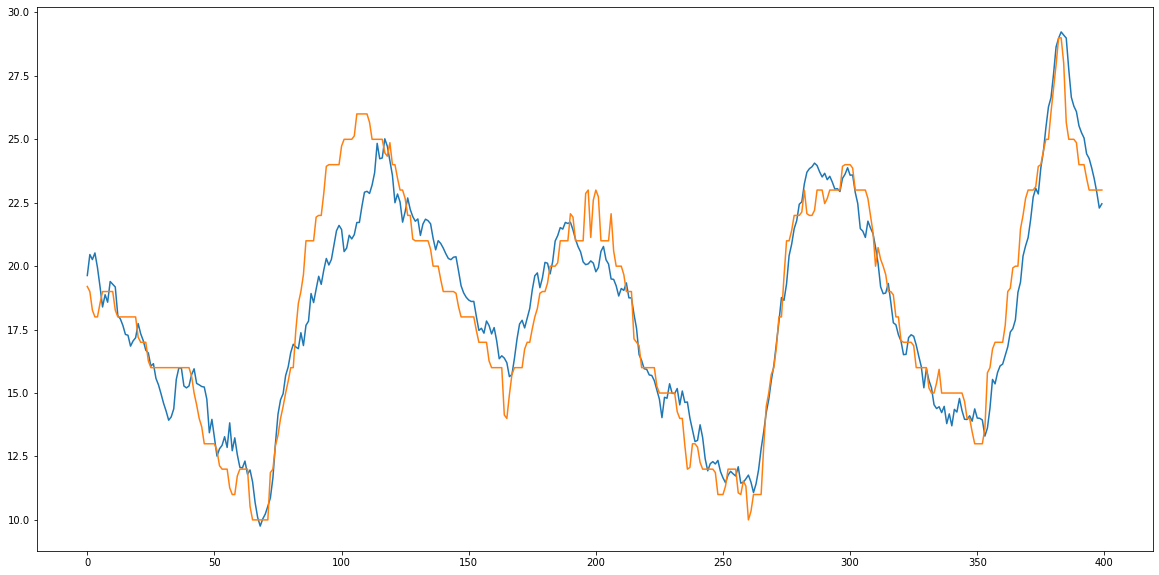

Iter:  81 train:  0.020065828358451155 val:  0.05966237068449976
Iter time:  0.5249218169999779
Iter:  82 train:  0.016513112981658758 val:  0.06051542295810766
Iter time:  0.5141076259999977
Iter:  83 train:  0.016560284630538984 val:  0.0604855941012998
Iter time:  0.5245181829999979
Iter:  84 train:  0.016867536465807114 val:  0.06060262989349839
Iter time:  0.5254584199999783
Iter:  85 train:  0.016911110601875633 val:  0.06098913151182481
Iter time:  0.5248507909999773
Iter:  86 train:  0.01605861465904091 val:  0.05965126524906951
Iter time:  0.5221533760000057
Iter:  87 train:  0.015547087932722388 val:  0.06134179093632973
Iter time:  0.5270867929999952
Saving...
Iter:  88 train:  0.016453717982968425 val:  0.057319424670818776
Iter time:  0.5258922730000108
Iter:  89 train:  0.017152454628127242 val:  0.06253041317187744
Iter time:  0.5269601990000012
Iter:  90 train:  0.01537848362816844 val:  0.06044293449534308
Iter time:  0.5275089700000137
mse:  1.7682205 mae:  1.0238835


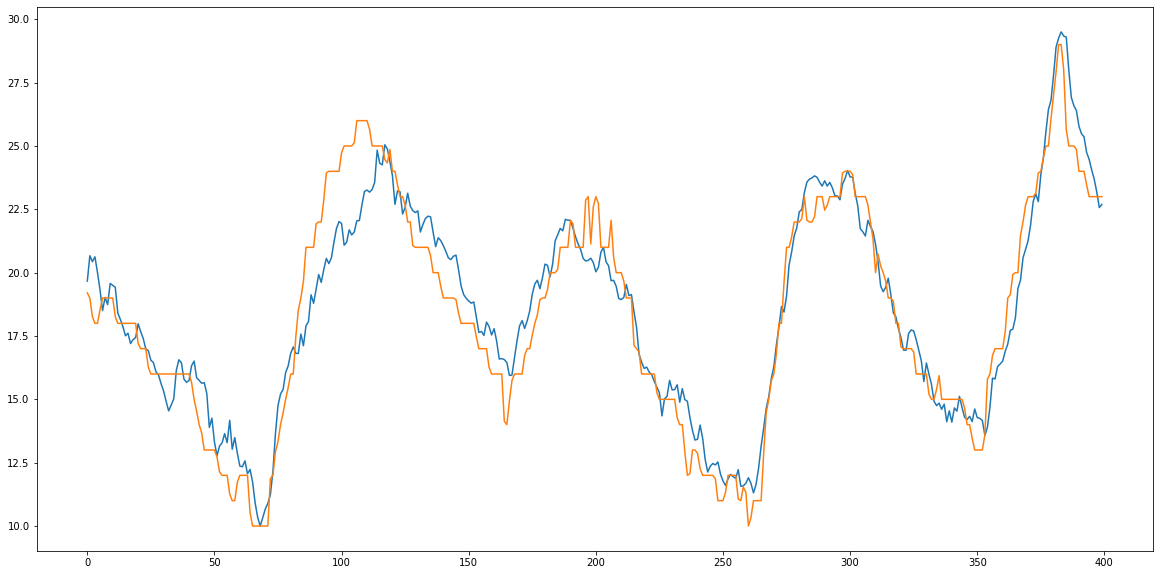

Saving...
Iter:  91 train:  0.01682043385740064 val:  0.0560462370427548
Iter time:  0.6148401879999881
Iter:  92 train:  0.01655089506574131 val:  0.059626151320200126
Iter time:  0.5274482590000105
Iter:  93 train:  0.015876745843013337 val:  0.05828838951520965
Iter time:  0.5207136770000034
Iter:  94 train:  0.01706968787934231 val:  0.05618601544098246
Iter time:  0.5392925379999838
Iter:  95 train:  0.015470400156369973 val:  0.05856803647722992
Iter time:  0.5140573840000116
Iter:  96 train:  0.016550690373439158 val:  0.06391472082961236
Iter time:  0.5199212429999989
Iter:  97 train:  0.014811839889734354 val:  0.05919367338541506
Iter time:  0.5258848379999961
Iter:  98 train:  0.014044554821753614 val:  0.06341196470561059
Iter time:  0.5240710219999869
Iter:  99 train:  0.01693807424919565 val:  0.058938468980762625
Iter time:  0.5264781889999881
Iter:  100 train:  0.013972755654375058 val:  0.05755285648039516
Iter time:  0.5197040959999981
mse:  1.6031684 mae:  0.9902521


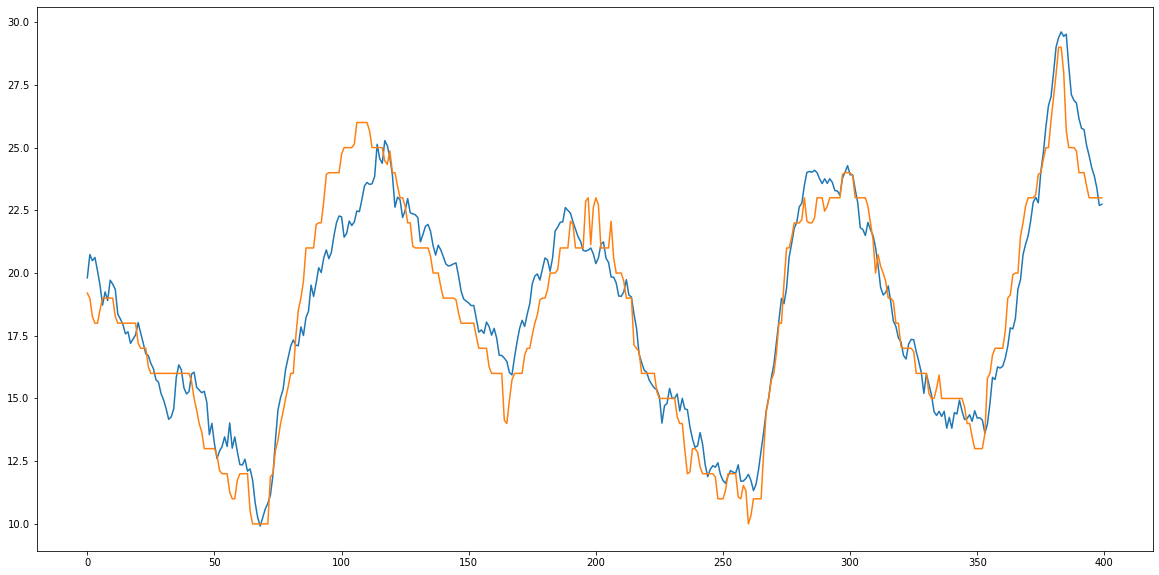

Iter:  101 train:  0.01467095176432964 val:  0.05770486722847267
Iter time:  0.5324648990000185
Iter:  102 train:  0.018600129559725467 val:  0.06005739629528669
Iter time:  0.5247163140000168
Iter:  103 train:  0.015869457456965507 val:  0.05732684316265164
Iter time:  0.5420245259999774
Iter:  104 train:  0.017943929881878953 val:  0.05682684114425569
Iter time:  0.5281935069999975
Iter:  105 train:  0.01567255354862671 val:  0.05871282367633322
Iter time:  0.5260285030000205
Iter:  106 train:  0.013916818483329391 val:  0.05970593257713057
Iter time:  0.5438400440000066
Iter:  107 train:  0.01583319364432419 val:  0.0628333350577837
Iter time:  0.5258678600000053
Iter:  108 train:  0.01708149463412812 val:  0.05871601461588538
Iter time:  0.5297682479999821
Iter:  109 train:  0.01293406791171379 val:  0.05904215073594587
Iter time:  0.5204114029999971
Iter:  110 train:  0.014314028444974232 val:  0.06028500902618542
Iter time:  0.5279827930000067
mse:  1.7589924 mae:  1.0540853


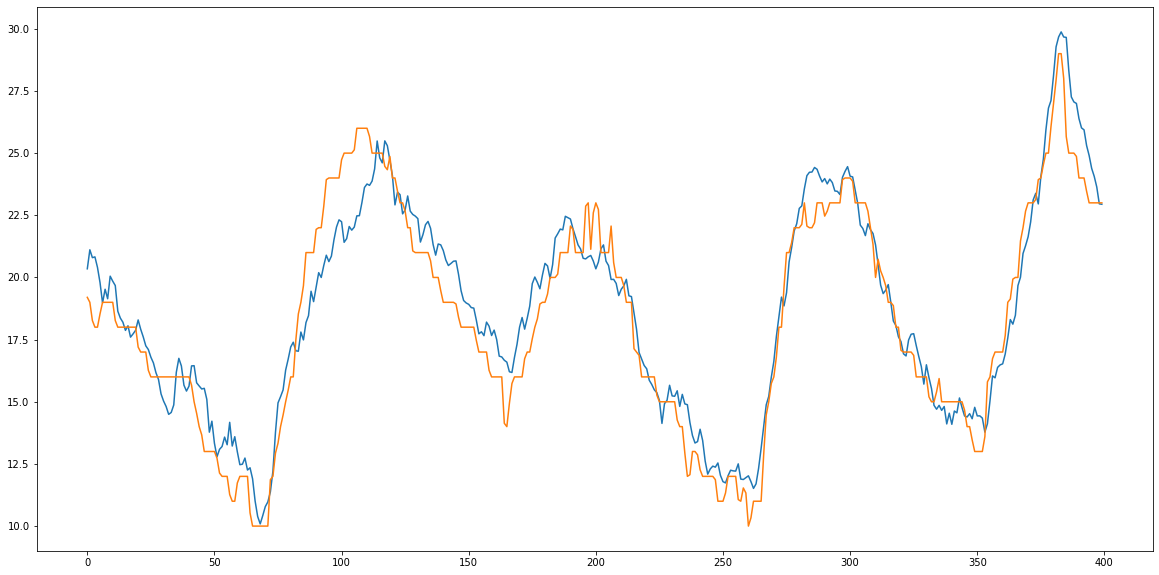

Iter:  111 train:  0.01643002614022306 val:  0.057921082590011747
Iter time:  0.535898904999982
Iter:  112 train:  0.014317550467667951 val:  0.05885682826156609
Iter time:  0.5318970890000116
Iter:  113 train:  0.013128788138947458 val:  0.05980000255181633
Iter time:  0.5308252800000162
Iter:  114 train:  0.015360285776246978 val:  0.05900549510494743
Iter time:  0.5266825350000204
Iter:  115 train:  0.01651739219123707 val:  0.05784059112698701
Iter time:  0.5236973789999979
Iter:  116 train:  0.015473468412143525 val:  0.05810029367433822
Iter time:  0.5203896010000051
Iter:  117 train:  0.01735113910037691 val:  0.056972546281469784
Iter time:  0.5226014060000068
Iter:  118 train:  0.013603863338725522 val:  0.056269596249437906
Iter time:  0.5251682199999834
Iter:  119 train:  0.012875011735298397 val:  0.05825451016309694
Iter time:  0.5277073499999858
Iter:  120 train:  0.012230173104476183 val:  0.0579556976003453
Iter time:  0.5206992319999983
mse:  1.6256894 mae:  1.0021983


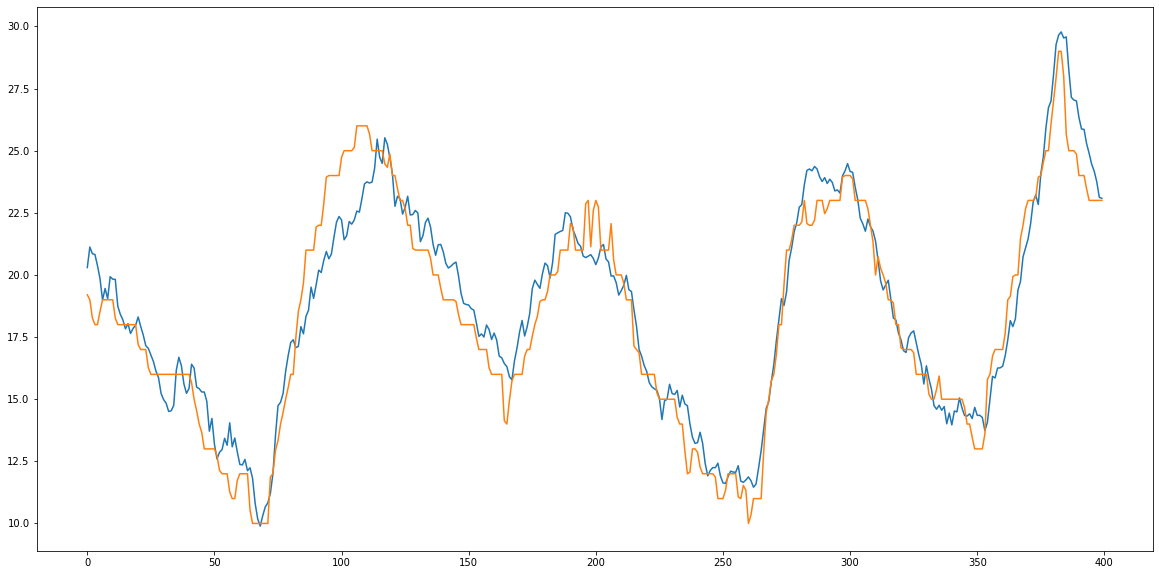

Iter:  121 train:  0.011913118608467933 val:  0.05852547912107206
Iter time:  0.5298579110000219
Iter:  122 train:  0.01231778909520893 val:  0.058596326612405
Iter time:  0.5260447330000204
Iter:  123 train:  0.013300108502059945 val:  0.058198763536726025
Iter time:  0.5287182799999925
Iter:  124 train:  0.01176260770533551 val:  0.058913387440404384
Iter time:  0.5266789140000014
Iter:  125 train:  0.013343955670816638 val:  0.06042854189634487
Iter time:  0.5213921780000135
Iter:  126 train:  0.013054253663256174 val:  0.05920610593568648
Iter time:  0.5259216580000157
Iter:  127 train:  0.011584518985512191 val:  0.05823420280536508
Iter time:  0.5403463090000002
Iter:  128 train:  0.013272545968757168 val:  0.058720843443265947
Iter time:  0.5213646670000003
Iter:  129 train:  0.017090176343389104 val:  0.067465260692406
Iter time:  0.5221533029999819
Iter:  130 train:  0.017900540218015015 val:  0.059956990338855265
Iter time:  0.5264975960000129
mse:  1.739903 mae:  1.0398736


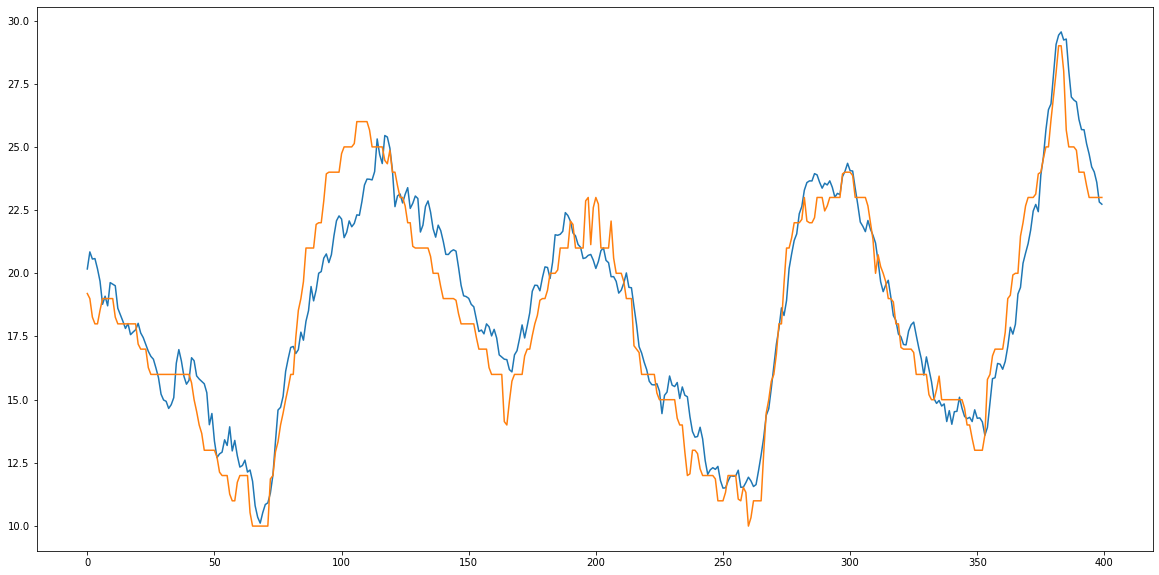

Iter:  131 train:  0.014383668187864917 val:  0.05782165326008587
Iter time:  0.525987487000009
Iter:  132 train:  0.014266745087607322 val:  0.05768285323028238
Iter time:  0.5263667190000092
Iter:  133 train:  0.015142756791188823 val:  0.060895110939296615
Iter time:  0.5249255420000054
Iter:  134 train:  0.014296390658703343 val:  0.059123846814793234
Iter time:  0.523995264000007
Iter:  135 train:  0.015094163907093509 val:  0.057875885560673725
Iter time:  0.5290471349999848
Iter:  136 train:  0.012595020951832934 val:  0.05789217227407313
Iter time:  0.5242569790000005
Iter:  137 train:  0.013756364517331084 val:  0.05899952479197379
Iter time:  0.5285432780000008
Iter:  138 train:  0.01418305982336362 val:  0.05890213003979302
Iter time:  0.5256431020000036
Iter:  139 train:  0.014005552360965227 val:  0.05740542273426326
Iter time:  0.5417414540000038
Iter:  140 train:  0.012033127735645901 val:  0.05873765392771399
Iter time:  0.526568688000026
mse:  1.6698542 mae:  1.013845


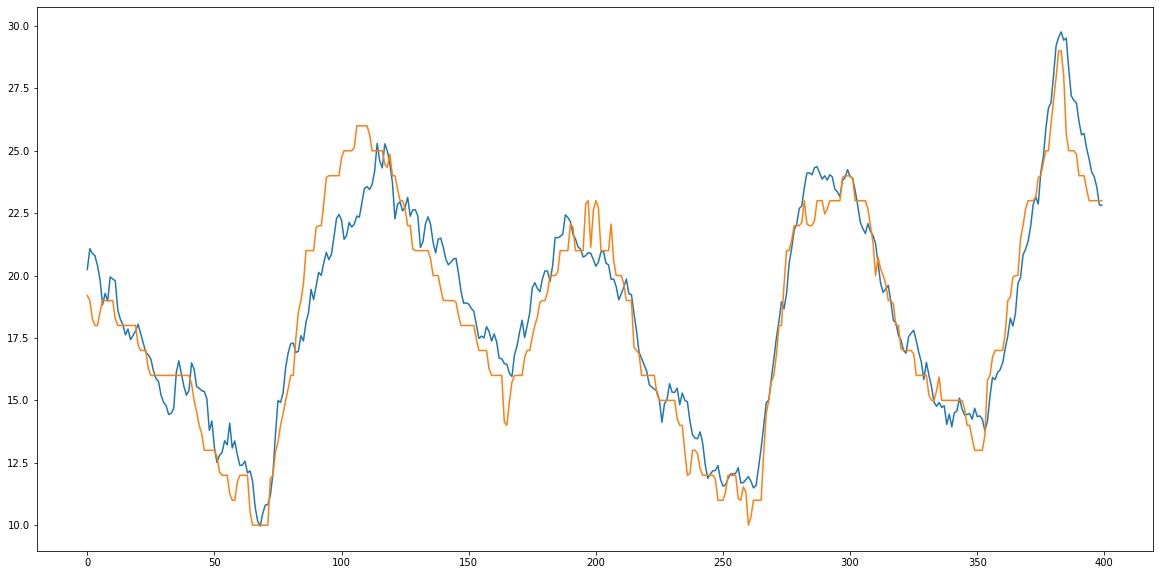

Iter:  141 train:  0.012648148681297832 val:  0.05836531152494492
Iter time:  0.5240087130000006
Iter:  142 train:  0.011771289162546132 val:  0.06131249732854528
Iter time:  0.5249493719999805
Iter:  143 train:  0.015512246653823818 val:  0.05926334649474943
Iter time:  0.5228762950000032
Iter:  144 train:  0.01159168728962642 val:  0.058657816511848926
Iter time:  0.5228514059999725
Iter:  145 train:  0.013276690929333267 val:  0.057380790999442016
Iter time:  0.5278160240000034
Iter:  146 train:  0.012766321896046031 val:  0.06026751057081129
Iter time:  0.5282311690000085
Iter:  147 train:  0.010225257192617482 val:  0.059479899349031286
Iter time:  0.519413921999984
Iter:  148 train:  0.010415489578145882 val:  0.05840172375647236
Iter time:  0.514162626000001
Iter:  149 train:  0.010636772143771869 val:  0.05628586857329285
Iter time:  0.5236090859999933
Iter:  150 train:  0.011371599327185164 val:  0.0625733937035794
Iter time:  0.5219700589999832
mse:  1.895068 mae:  1.1314815


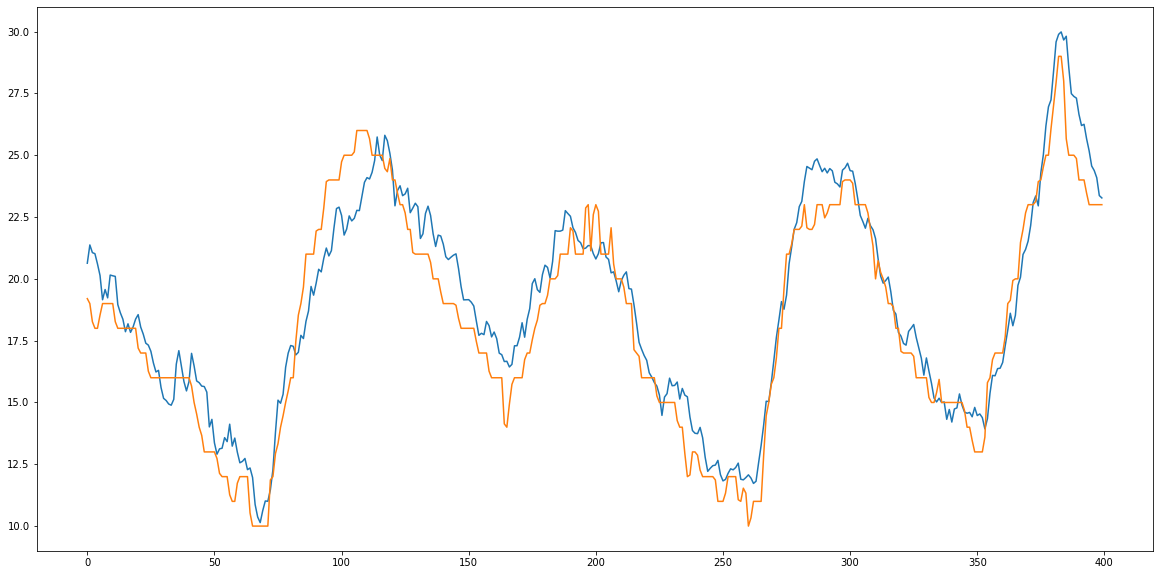

Iter:  151 train:  0.015176718366423545 val:  0.061357829317072475
Iter time:  0.5220001559999901
Iter:  152 train:  0.013452195742164018 val:  0.06307686247375956
Iter time:  0.5258472790000042
Iter:  153 train:  0.012597111171728907 val:  0.05876411244394
Iter time:  0.5203337520000275
Iter:  154 train:  0.012051092447872816 val:  0.062387873086633495
Iter time:  0.5229674409999916
Iter:  155 train:  0.012916143677459248 val:  0.06237327991332763
Iter time:  0.512856510000006
Iter:  156 train:  0.015403150026184262 val:  0.059838599488847476
Iter time:  0.5246816210000134
Iter:  157 train:  0.020885459132773558 val:  0.05863236267659394
Iter time:  0.5225855139999851
Iter:  158 train:  0.020443009500009185 val:  0.059958843728951196
Iter time:  0.5252395599999886
Iter:  159 train:  0.015038977845060086 val:  0.058525897316192975
Iter time:  0.5162357429999815
Iter:  160 train:  0.012114591554697416 val:  0.061448135008011516
Iter time:  0.5323528199999998
mse:  1.8275226 mae:  1.0810

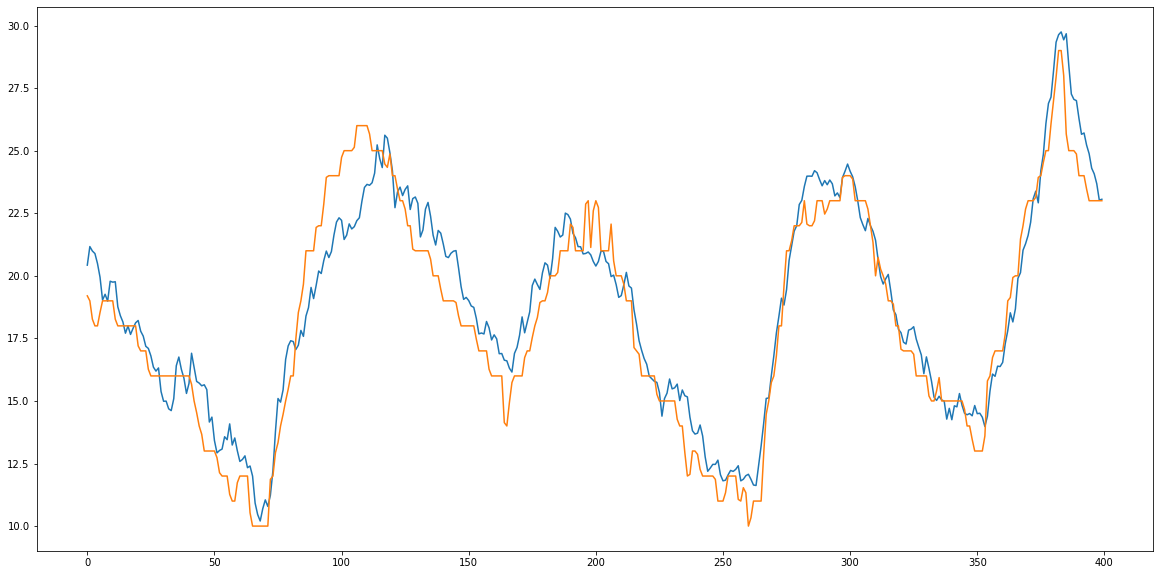

Iter:  161 train:  0.013125699258590357 val:  0.058132941218847434
Iter time:  0.5281359340000051
Iter:  162 train:  0.010696830541047763 val:  0.06035474534268111
Iter time:  0.523053912999984
Iter:  163 train:  0.010661017467458853 val:  0.059408351979901776
Iter time:  0.5265438710000012
Iter:  164 train:  0.011185448825514114 val:  0.057549667235762124
Iter time:  0.5299962799999776
Iter:  165 train:  0.009712102872273328 val:  0.06025998101919086
Iter time:  0.5232212530000311


In [27]:
epochs = 1000
loss = nn.MSELoss()
patience = 75
min_val_loss = 9999
counter = 0
for i in range(epochs):
    mse_train = 0
    iteration_start = time.monotonic()
    for batch_x, batch_y in train_loader :
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        opt.zero_grad()
        y_pred = model(batch_x)
        y_pred = y_pred.squeeze(1)
        l = loss(y_pred, batch_y)
        l.backward()
        mse_train += l.item()*batch_x.shape[0]
        opt.step()
    epoch_scheduler.step()
    with torch.no_grad():
        mse_val = 0
        preds = []
        true = []
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            output = model(batch_x)
            output = output.squeeze(1)
            preds.append(output.detach().cpu().numpy())
            true.append(batch_y.detach().cpu().numpy())
            mse_val += loss(output, batch_y).item()*batch_x.shape[0]
    preds = np.concatenate(preds)
    true = np.concatenate(true)
    
    if min_val_loss > mse_val**0.5:
        min_val_loss = mse_val**0.5
        print("Saving...")
        torch.save(model.state_dict(), "convrnn_sml2010.pt")
        counter = 0
    else: 
        counter += 1
    
    if counter == patience:
        break
    print("Iter: ", i, "train: ", (mse_train/len(X_train_t))**0.5, "val: ", (mse_val/len(X_val_t))**0.5)
    iteration_end = time.monotonic()
    print("Iter time: ", iteration_end - iteration_start)
    if(i % 10 == 0):
        preds = preds*(y_train_max - y_train_min) + y_train_min
        true = true*(y_train_max - y_train_min) + y_train_min
        mse = mean_squared_error(true, preds)
        mae = mean_absolute_error(true, preds)
        print("mse: ", mse, "mae: ", mae)
        plt.figure(figsize=(20, 10))
        plt.plot(preds)
        plt.plot(true)
        plt.show()

In [29]:
model.load_state_dict(torch.load("convrnn_sml2010.pt"))


<All keys matched successfully>

In [30]:
with torch.no_grad():
    mse_val = 0
    preds = []
    true = []
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        output = model(batch_x)
        output = output.squeeze(1)
        preds.append(output.detach().cpu().numpy())
        true.append(batch_y.detach().cpu().numpy())
        mse_val += loss(output, batch_y).item()*batch_x.shape[0]
preds = np.concatenate(preds)
true = np.concatenate(true)

In [32]:
preds = preds*(y_train_max - y_train_min) + y_train_min
true = true*(y_train_max - y_train_min) + y_train_min

In [33]:
mse = mean_squared_error(true, preds)
mae = mean_absolute_error(true, preds)

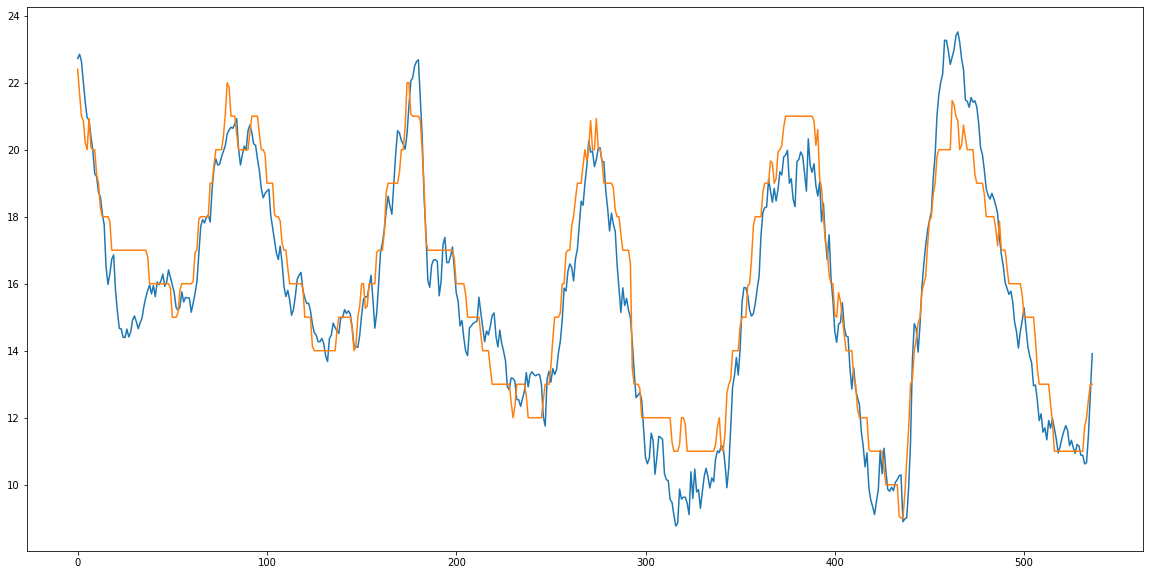

In [34]:
plt.figure(figsize=(20, 10))
plt.plot(preds)
plt.plot(true)
plt.show()